Optimisation de l'entrainement pour `focus` 
This is the same function as used in `10_Transfer_learning_what_networks.ipynb`
> ... TODO ... # TODO test without circular padding, with Adam, with no warmstart 

    model = torchvision.models.resnet18(weights=None)

# optimize meta-parameters

In [1]:
import dataclasses

In [2]:
# print_gpu_memory()

# print(path_save)
# %ls -l {path}*

# %rm "cached_data/34_optuna.sqlite3"  # FORCING RECOMPUTE

In [3]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [4]:
import retinoto_py as fovea
dataset = 'bbox'
batch_size = 64
args = fovea.Params()
opts_dict = dict(do_fovea=True, num_epochs=1, verbose=False)
args = dataclasses.replace(args, **opts_dict)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 2018 has been set.


Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=4, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=1, n_train_stop=40960, n_val_stop=5120, do_full_training=False, lr=5e-06, delta1=0.3, delta2=0.001, weight_decay=0.05, label_smoothing=0.03, shuffle=True, verbose=False)

In [5]:
import retinoto_py as fovea
dataset = 'bbox'
# batch_size = 64
args = fovea.Params(do_fovea=True, num_epochs=1, verbose=False)
args

Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=4, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=1, n_train_stop=40960, n_val_stop=5120, do_full_training=False, lr=5e-06, delta1=0.3, delta2=0.001, weight_decay=0.05, label_smoothing=0.03, shuffle=True, verbose=False)

In [6]:
%ls -ltr cached_data/32*

-rw-r--r--  1 laurent  staff  178843891 27 nov.  09:12 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.pth
-rw-r--r--  1 laurent  staff       2132 27 nov.  09:47 cached_data/32_fovea_model_name=resnet101_dataset=bbox_retrained_bkp.json
-rw-r--r--  1 laurent  staff       2140 27 nov.  18:05 cached_data/32_fovea_model_name=resnet101_dataset=full.json
-rw-r--r--  1 laurent  staff          0 27 nov.  19:37 cached_data/32_fovea_model_name=resnet101_dataset=full.lock
-rw-r--r--  1 laurent  staff  178837571 27 nov.  20:42 cached_data/32_fovea_model_name=resnet101_dataset=full.pth
-rw-r--r--  1 laurent  staff          0 27 nov.  23:43 cached_data/32_fovea_model_name=resnet101_dataset=bbox.lock
-rw-r--r--  1 laurent  staff  178837571 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.pth
-rw-r--r--  1 laurent  staff       1955 28 nov.  09:05 cached_data/32_fovea_model_name=resnet101_dataset=bbox.json


In [7]:
# model_filename = None # do not use resumed net
# model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}_retrained_bkp.pth'
# model_filename = args.data_cache / f'32_fovea_model_name={args.model_name}_dataset={dataset}.pth'
model_filename = args.data_cache / f'33_fovea_model_name={args.model_name}_dataset={dataset}.pth'


In [8]:
TRAIN_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'train'
train_dataset = fovea.get_dataset(args, TRAIN_DATA_DIR, n_stop=args.n_train_stop)
train_loader = fovea.get_loader(args, train_dataset)
VAL_DATA_DIR = args.DATAROOT / f'Imagenet_{dataset}' / 'val'
val_dataset = fovea.get_dataset(args, VAL_DATA_DIR, n_stop=args.n_val_stop)
val_loader = fovea.get_loader(args, val_dataset)

Putting images in memory:   0%|          | 0/40960 [00:00<?, ?it/s]

Putting images in memory:   0%|          | 0/5120 [00:00<?, ?it/s]

In [9]:
def objective(trial):
    args = fovea.Params(do_fovea=True, num_epochs=1, verbose=False)

    model = fovea.load_model(args, model_filename=model_filename)

    # args.do_full_training = trial.suggest_categorical("do_full_training", [True, False])
    # # args.batch_size = trial.suggest_int('batch_size', 16, 512, log=True, step=1)
    # # args.rs_min = trial.suggest_float('rs_min', -1, 1.)
    # # args.rs_max = trial.suggest_float('rs_max', -7, -4)
    scale = 10
    if args.delta2>0: args.delta2 = trial.suggest_float('delta2', args.delta2 / scale, min((args.delta2 * scale, 1)), log=True)
    args.lr = trial.suggest_float('lr', args.lr / scale, args.lr * scale, log=True)

    args.delta1 = trial.suggest_float('delta1', args.delta1 / scale, min((args.delta1 * scale, 1)), log=True)
    if args.weight_decay>0: args.weight_decay = trial.suggest_float('weight_decay', args.weight_decay / scale, args.weight_decay * scale, log=True)
    if args.label_smoothing>0: args.label_smoothing = trial.suggest_float('label_smoothing', args.label_smoothing / scale, args.label_smoothing * scale, log=True)

    scale = 100 

    # args.im_mean = trial.suggest_float('im_mean', opt.im_mean / scale, opt.im_mean * scale, log=True)
    # args.im_std = trial.suggest_float('im_std', opt.im_std / scale, opt.im_std * scale, log=True)


    # get the architecture of the network, train and get accuracy on the validation set
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
    accuracy = df_train['acc_val'].mean()
    
    return accuracy
    
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(storage=f"sqlite:///cached_data/34_optuna.sqlite3", 
                            sampler=optuna.samplers.TPESampler(multivariate=False, warn_independent_sampling=False),
                            direction='maximize', load_if_exists=True, study_name=f"34_optuna")
print(f'Starting optimization with params: {args} on {max(150-len(study.trials), 0)} trials - {len(study.trials)} ')
study.optimize(objective, n_trials=max((150-len(study.trials), 0)), n_jobs=1, show_progress_bar=True)

print(50*'-.')
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
# print("Trials: ", study.trials)

Starting optimization with params: Params(image_size=224, do_mask=False, do_fovea=True, rs_min=0.0, rs_max=-5.0, padding_mode='zeros', seed=2018, batch_size=80, num_workers=4, in_memory=True, model_name='convnext_base', do_scratch=False, num_epochs=1, n_train_stop=40960, n_val_stop=5120, do_full_training=False, lr=5e-06, delta1=0.3, delta2=0.001, weight_decay=0.05, label_smoothing=0.03, shuffle=True, verbose=False) on 93 trials - 57 


  0%|          | 0/93 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

Vat @Epoch 1/1:   0%|          | 0/64 [00:00<?, ?it/s]

epoch=1/1:   0%|          | 0/512 [00:00<?, ?it/s]

[W 2025-11-30 07:51:48,022] Trial 107 failed with parameters: {'delta2': 0.0031765805139277125, 'lr': 5.212285382331605e-06, 'delta1': 0.34817675995845687, 'weight_decay': 0.2446035208078757, 'label_smoothing': 0.02507785907907568} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/.venv/lib/python3.14/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_65092/357449951.py", line 25, in objective
    _, df_train = fovea.train_model(args, model=model, train_loader=train_loader, val_loader=val_loader)
                  ~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/laurent/app54_nextcloud/science/retinoto_py/src/retinoto_py/retinoto_py.py", line 161, in train_model
    optimizer.step()
    ~~~~~~~~~~~~~~^^
  File "/Users/lauren

KeyboardInterrupt: 

In [10]:
import optuna.visualization.matplotlib as vis

/var/folders/qt/n82pbkv93fjb7bpt0pj1992w0000gn/T/ipykernel_65092/173483681.py:1: ExperimentalWarning: optuna.visualization.matplotlib._param_importances.plot_param_importances is experimental (supported from v2.2.0). The interface can change in the future.
  vis.plot_param_importances(study)


<Axes: title={'left': 'Hyperparameter Importances'}, xlabel='Hyperparameter Importance', ylabel='Hyperparameter'>

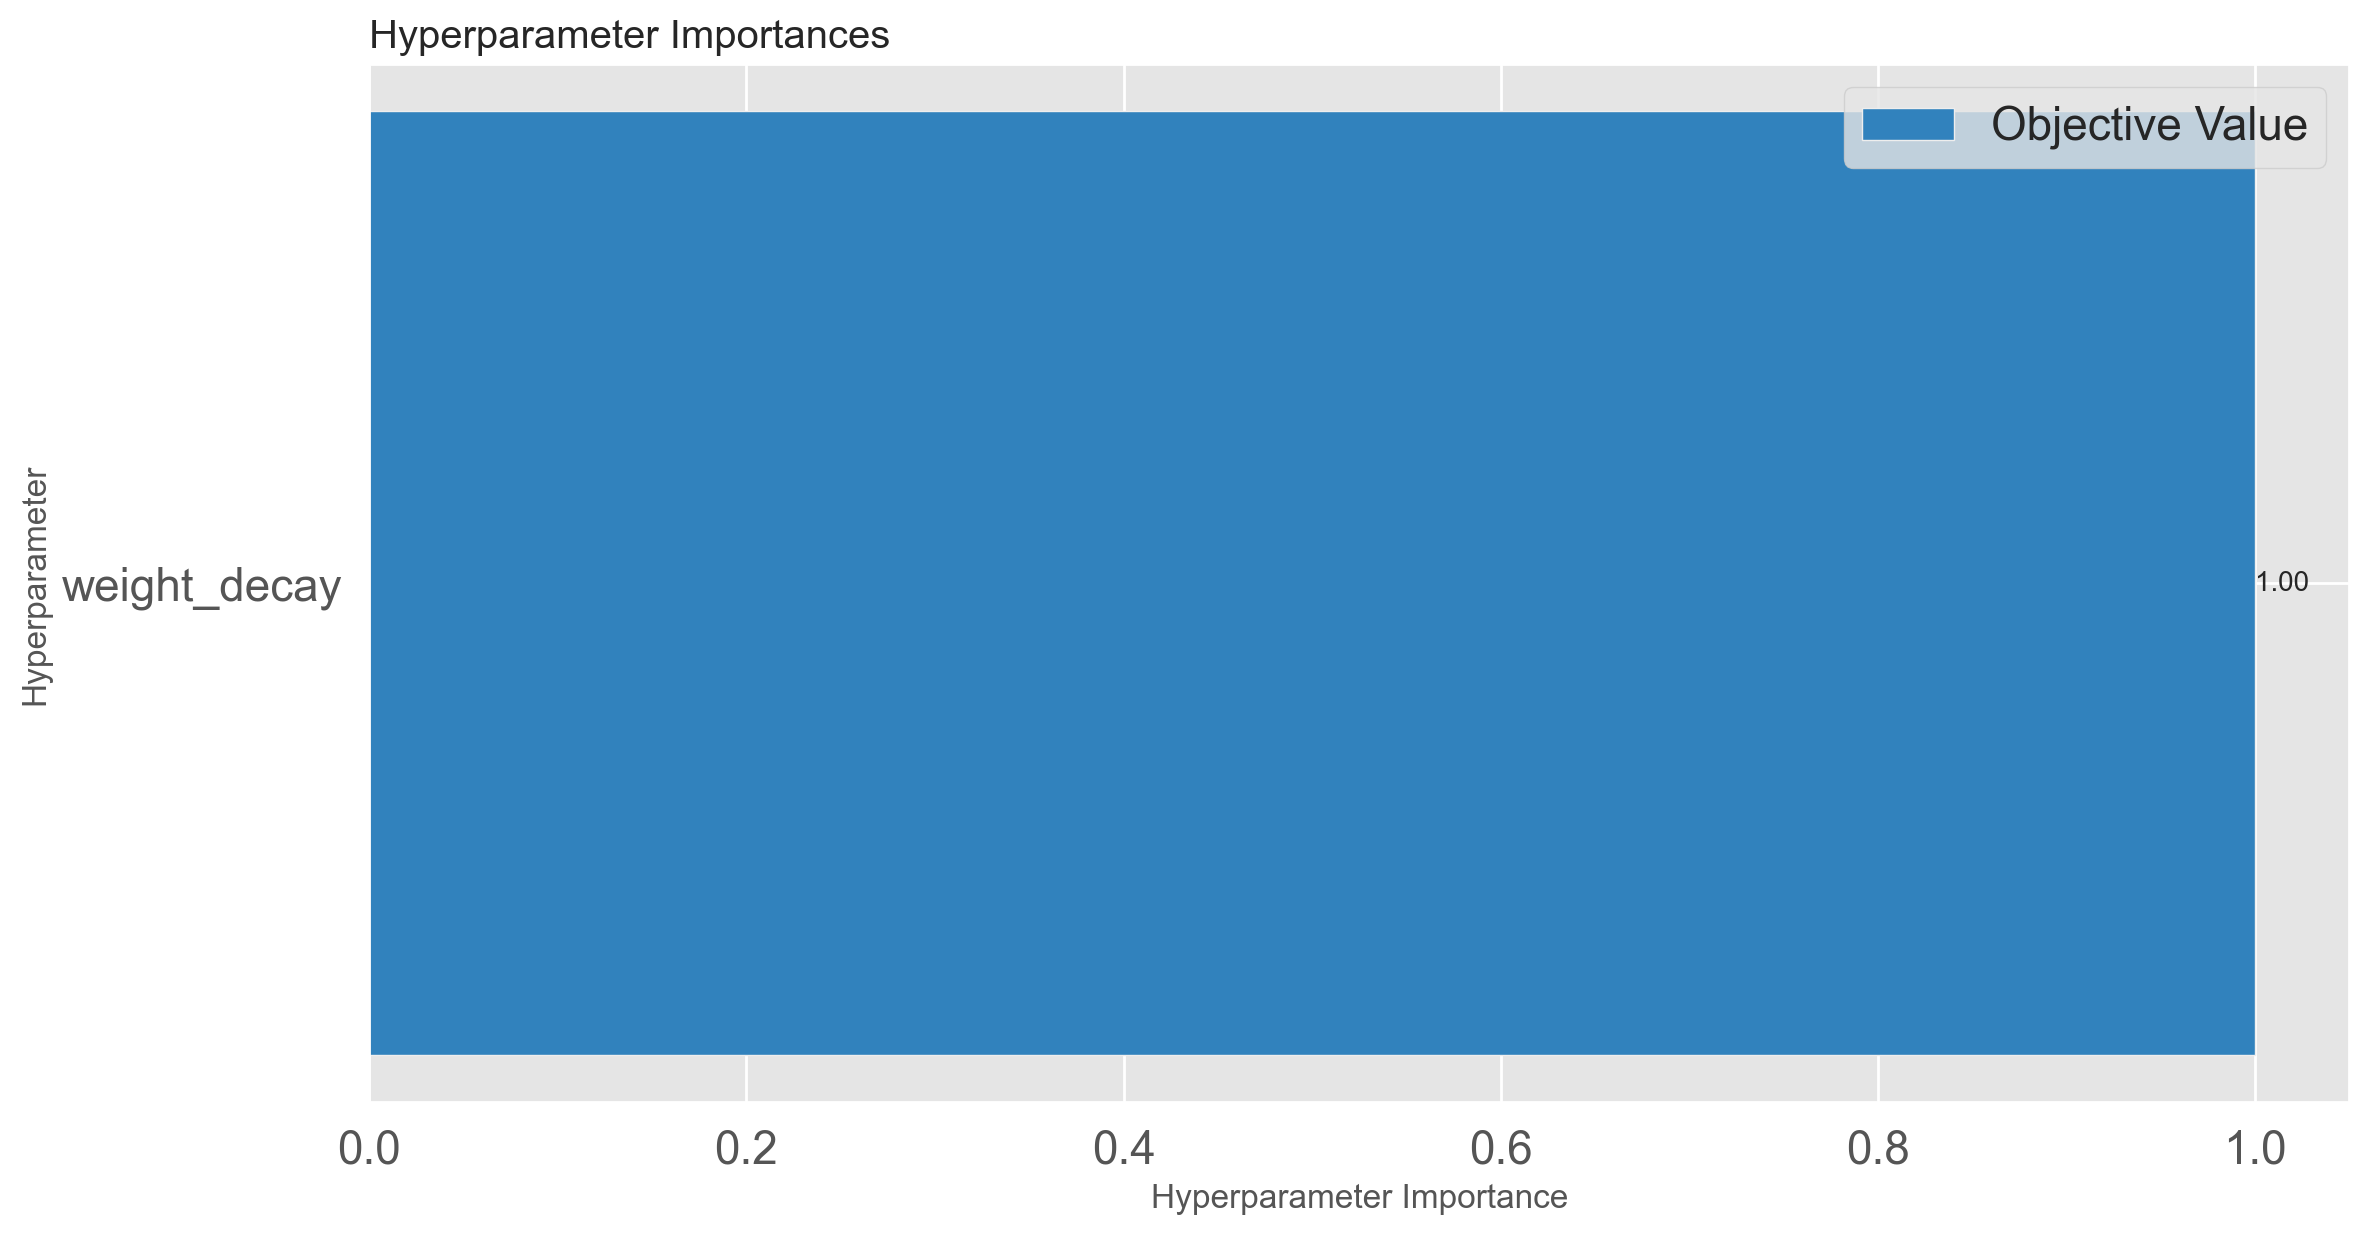

In [11]:
vis.plot_param_importances(study)

In [12]:
# df = study.trials_dataframe()   
params = sorted({k for t in study.trials for k in t.params})
params

['delta1', 'delta2', 'label_smoothing', 'lr', 'weight_decay']

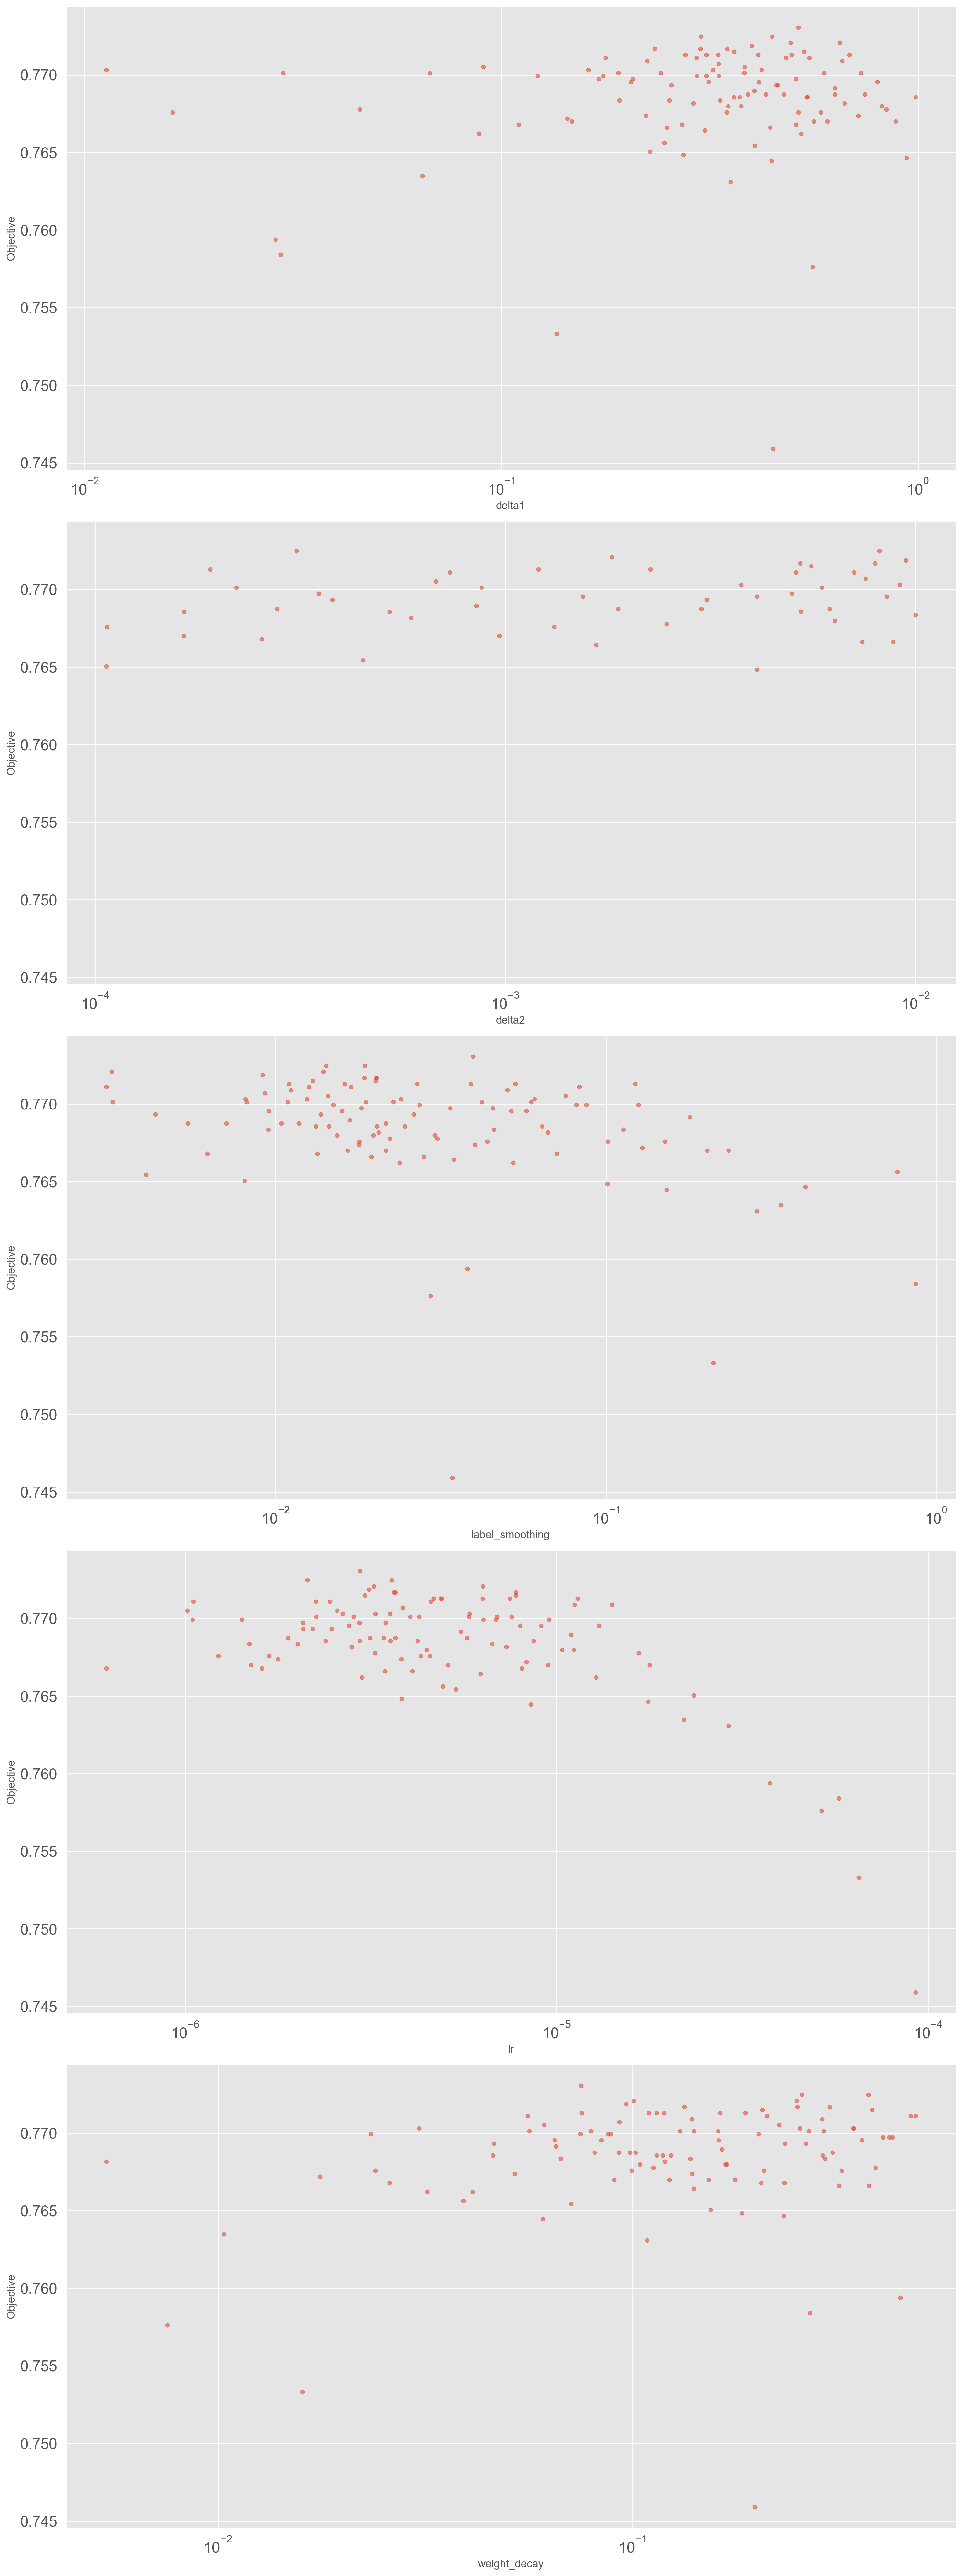

In [13]:
fig, axes = fovea.plt.subplots(len(params), 1, figsize=(15, 8*len(params)), sharey=True)

for ax, pname in zip(axes, params):
    xs = [t.params[pname] for t in study.trials if pname in t.params]
    ys = [t.value for t in study.trials if pname in t.params]
    ax.scatter(xs, ys, s=20, alpha=0.6)
    ax.set_xlabel(pname)
    ax.set_xscale('log')
    ax.set_ylabel("Objective")

fovea.plt.tight_layout()

In [14]:
# vis.plot_contour(study, params=["weight_quanta", "resample_rate"])
# vis.plot_contour(study, params=["num_particles", "chunk_size"])